## An치lisis

En este notebook vamos a hacer un an치lisis de las distintas competiciones (las cinco grandes ligas durante la temporada 2015-2016) y de todos los partidos en general para poder entender que caracter칤sticas son m치s importantes a la hora de tomar la decisi칩n por parte del modelo de ML para decidir si el equipo va a ganar, perder o empatar el partido.

In [1]:
import shap
import pandas as pd
import numpy as np

### La Liga temporada 2015/2016 (masculina)

Cargamos los datos de los partidos sobre La Liga en la temporada 2015/2016 masculina para entrenar el modelo y poder hacer el estudio de explicabilidad.

In [2]:
import os


competition_name = "La Liga"
competition_gender = "male"
season_name_for_filename = "2015_2016"

output_dir = "data/reduced/"
filename = f"{competition_name}({season_name_for_filename}_{competition_gender})_reduced.csv"
output_path = os.path.join(output_dir, filename)

if os.path.exists(output_path):
    print(f"Matches from the competition loaded from {output_path}")
    matches_in_LaLiga = pd.read_csv(output_path)
else:
    print("You don't have data from the competition yet. Please run the notebook '0_datasets_building.ipynb' first.")

Matches from the competition loaded from data/reduced/La Liga(2015_2016_male)_reduced.csv


In [3]:
matches_in_LaLiga.head(5)

match_id  shots_on_target_ratio_home  shots_on_target_ratio_away  \
0   3825565                    0.400000                    0.153846   
1   3825564                    0.312500                    0.300000   
2    266236                    0.333333                    0.400000   
3   3825570                    0.461538                    0.400000   
4   3825562                    0.153846                    0.200000   

   average_shots_on_target_distance_home  \
0                              20.462904   
1                              25.239973   
2                              33.431447   
3                              24.394269   
4                              20.432657   

   average_shots_on_target_distance_away  shots_inside_area_ratio_home  \
0                              15.923442                      0.600000   
1                              18.652679                      0.187500   
2                              11.773407                      0.500000   
3                               9.439840                      0.538462   
4                              19.849825                      0.384615   

   shots_inside_area_ratio_away  pass_success_ratio_home  \
0                      0.384615                 0.630915   
1                      0.600000                 0.759191   
2                      0.700000                 0.609065   
3                      0.800000                 0.760377   
4                      0.800000                 0.775176   

   pass_success_ratio_away  cross_success_ratio_home  ...  \
0                 0.804089                  0.000000  ...   
1                 0.690647                  0.285714  ...   
2                 0.809783                  0.125000  ...   
3                 0.676543                  0.125000  ...   
4                 0.700581                  0.416667  ...   

   percentage_shots_under_pressure_home  \
0                              0.500000   
1                              0.666667   
2                              0.166667   
3                              0.500000   
4                              0.500000   

   percentage_shots_inside_area_under_pressure_home  \
0                                          1.000000   
1                                          0.000000   
2                                          0.250000   
3                                          0.666667   
4                                          0.000000   

   percentage_passes_under_pressure_home  \
0                               0.364780   
1                               0.476190   
2                               0.196491   
3                               0.582857   
4                               0.555556   

   percentage_passes_inside_area_under_pressure_home  \
0                                           0.000000   
1                                           0.333333   
2                                           0.400000   
3                                           1.000000   
4                                           0.750000   

   percentage_set_piece_shots_home  \
0                         0.214286   
1                         0.470588   
2                         0.333333   
3                         0.600000   
4                         0.615385   

   percentage_set_piece_shots_inside_area_home  percentage_substitutions_home  \
0                                     0.285714                            0.5   
1                                     0.000000                            0.5   
2                                     0.250000                            0.5   
3                                     0.444444                            0.5   
4                                     0.384615                            0.5   

   percentage_tactical_substitutions_home  percentage_tactical_changes_home  \
0                                    0.40                          1.000000   
1                                    0.50                          1.000

Una vez ya tenemos los datos cargados, entrenamos el mejor modelo y mostramos sus resultados.

In [4]:
from src.analysis import laliga_best_model


best_model_LaLiga, evaluation_metrics, X_train_reduced_LaLiga, X_test_reduced_LaLiga, feature_names_reduced_LaLiga, encoder_LaLiga, match_ids_test = laliga_best_model(matches_in_LaLiga)
print(f"The best model for La Liga is {best_model_LaLiga}")
print(f"The evaluation metrics for the best model are:")
evaluation_metrics.head()

The best model for La Liga is LogisticRegression(C=0.29354310869235306, max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
The evaluation metrics for the best model are:


Train Accuracy  Test Accuracy  Precision Macro  \
Logistic Regression MI        0.766447       0.723684         0.702033   

                        Precision Weighted  Recall Macro  Recall Weighted  \
Logistic Regression MI            0.717442      0.684041         0.723684   

                        F1 Macro  F1 Weighted  
Logistic Regression MI  0.690678     0.718346

Una vez ya tenemos el mejor modelo entrenado comenzamos el an치lisis de explicabilidad. Vamos a comenzar por un estudio global. 

En este caso, al ser el mejor modelo Logistic Regression, vamos a fijarnos en el coeficiente (m칠todo coef_) que nos aporta el modelo para cada caracter칤stica en cada clase. 
- Con esto, estamos observando la importancia global de cada caracter칤stica para cada clase en t칠rminos de una relaci칩n lineal. Es decir, estamos observando relaciones exclusivamente lineales entre las caracter칤sticas y la predicci칩n.
- Con esto, no se tiene en cuenta las interacciones entre caracter칤sticas ni tampoco explica predicciones individuales.

Los gr치ficos que se aparecen a continuaci칩n muestran la importancia de cada caracter칤stica para predecir una determinada clase de resultado en los partidos de LaLiga. Las clases son:
- Clase "away_team": Indica qu칠 caracter칤sticas influyen en que el equipo visitante gane el partido.
- Clase "draw": Indica qu칠 caracter칤sticas influyen en que el partido termine en empate.
- Clase "home_team": Indica qu칠 caracter칤sticas influyen en que el equipo local gane el partido.

Los valores representados en el eje X son los coeficientes de la regresi칩n log칤stica, que indican la magnitud e impacto de cada variable en la probabilidad de un resultado espec칤fico. Valores positivos aumentan la probabilidad de que ocurra esa clase, mientras que valores negativos disminuyen dicha probabilidad.

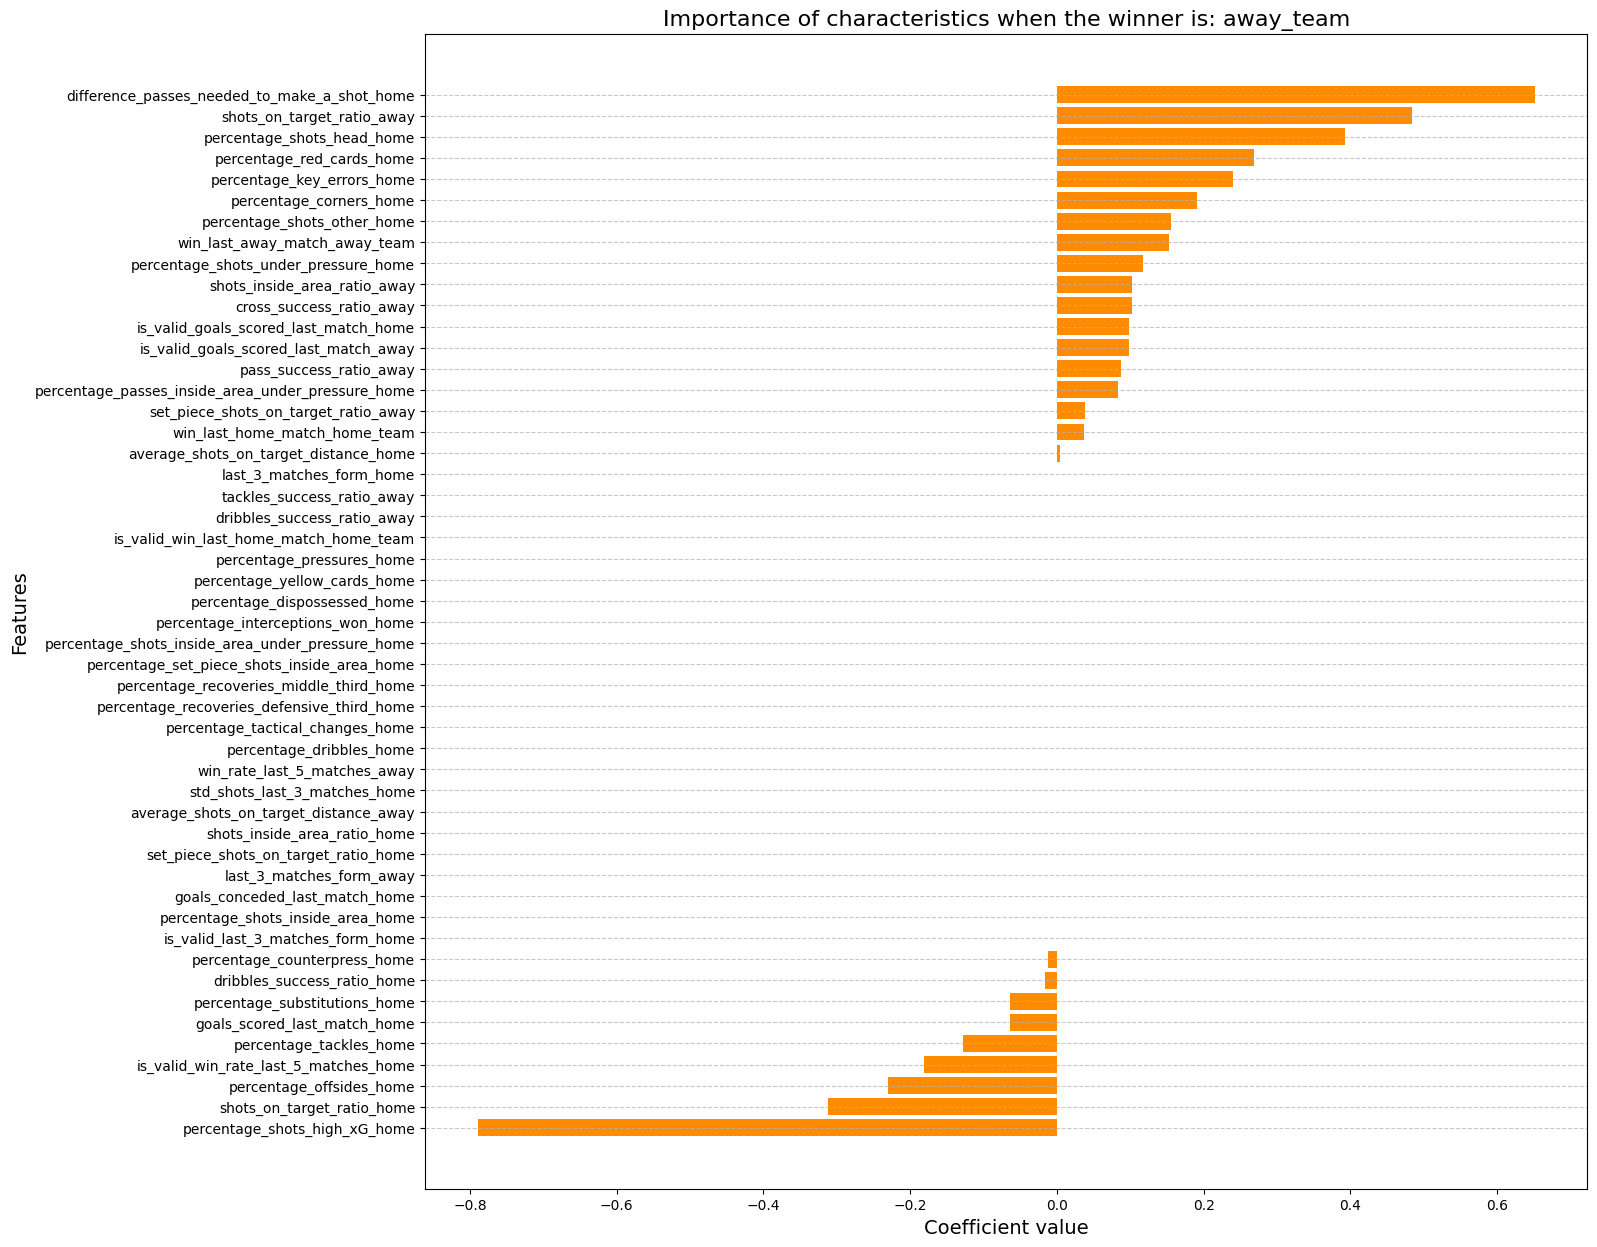

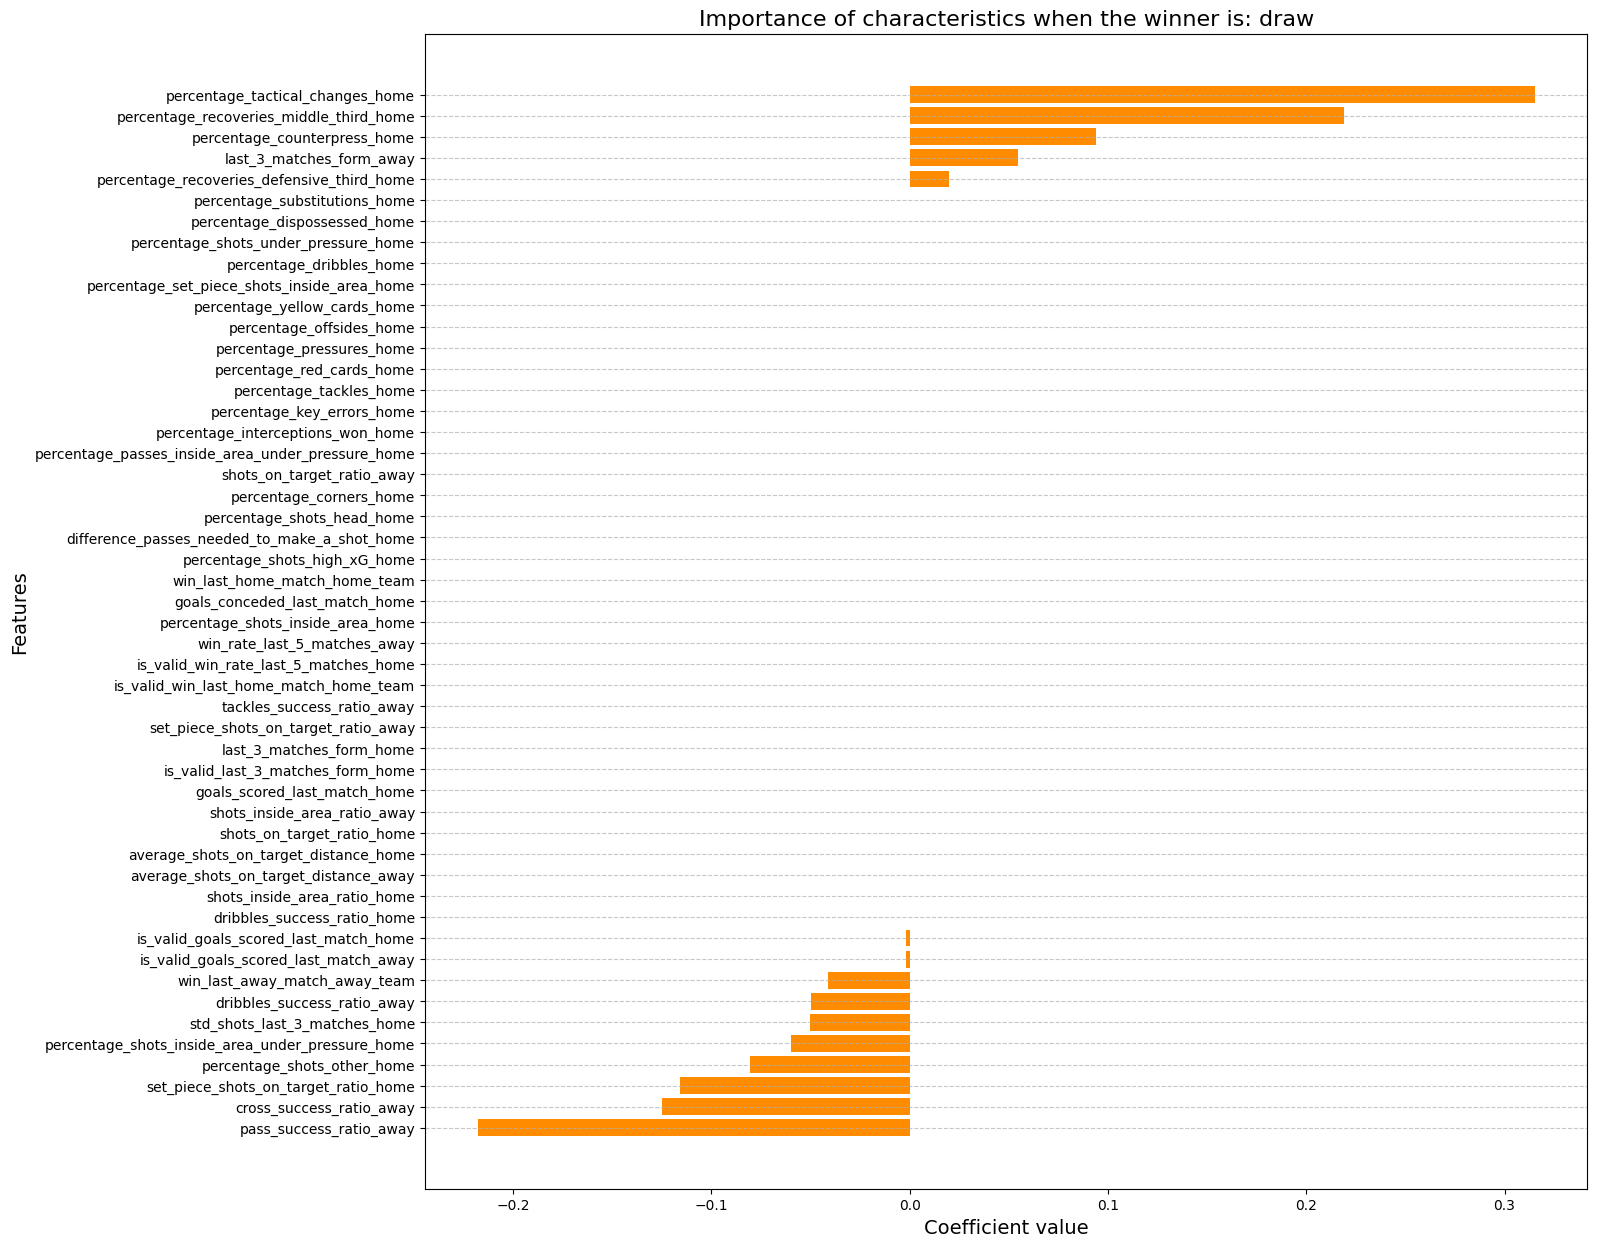

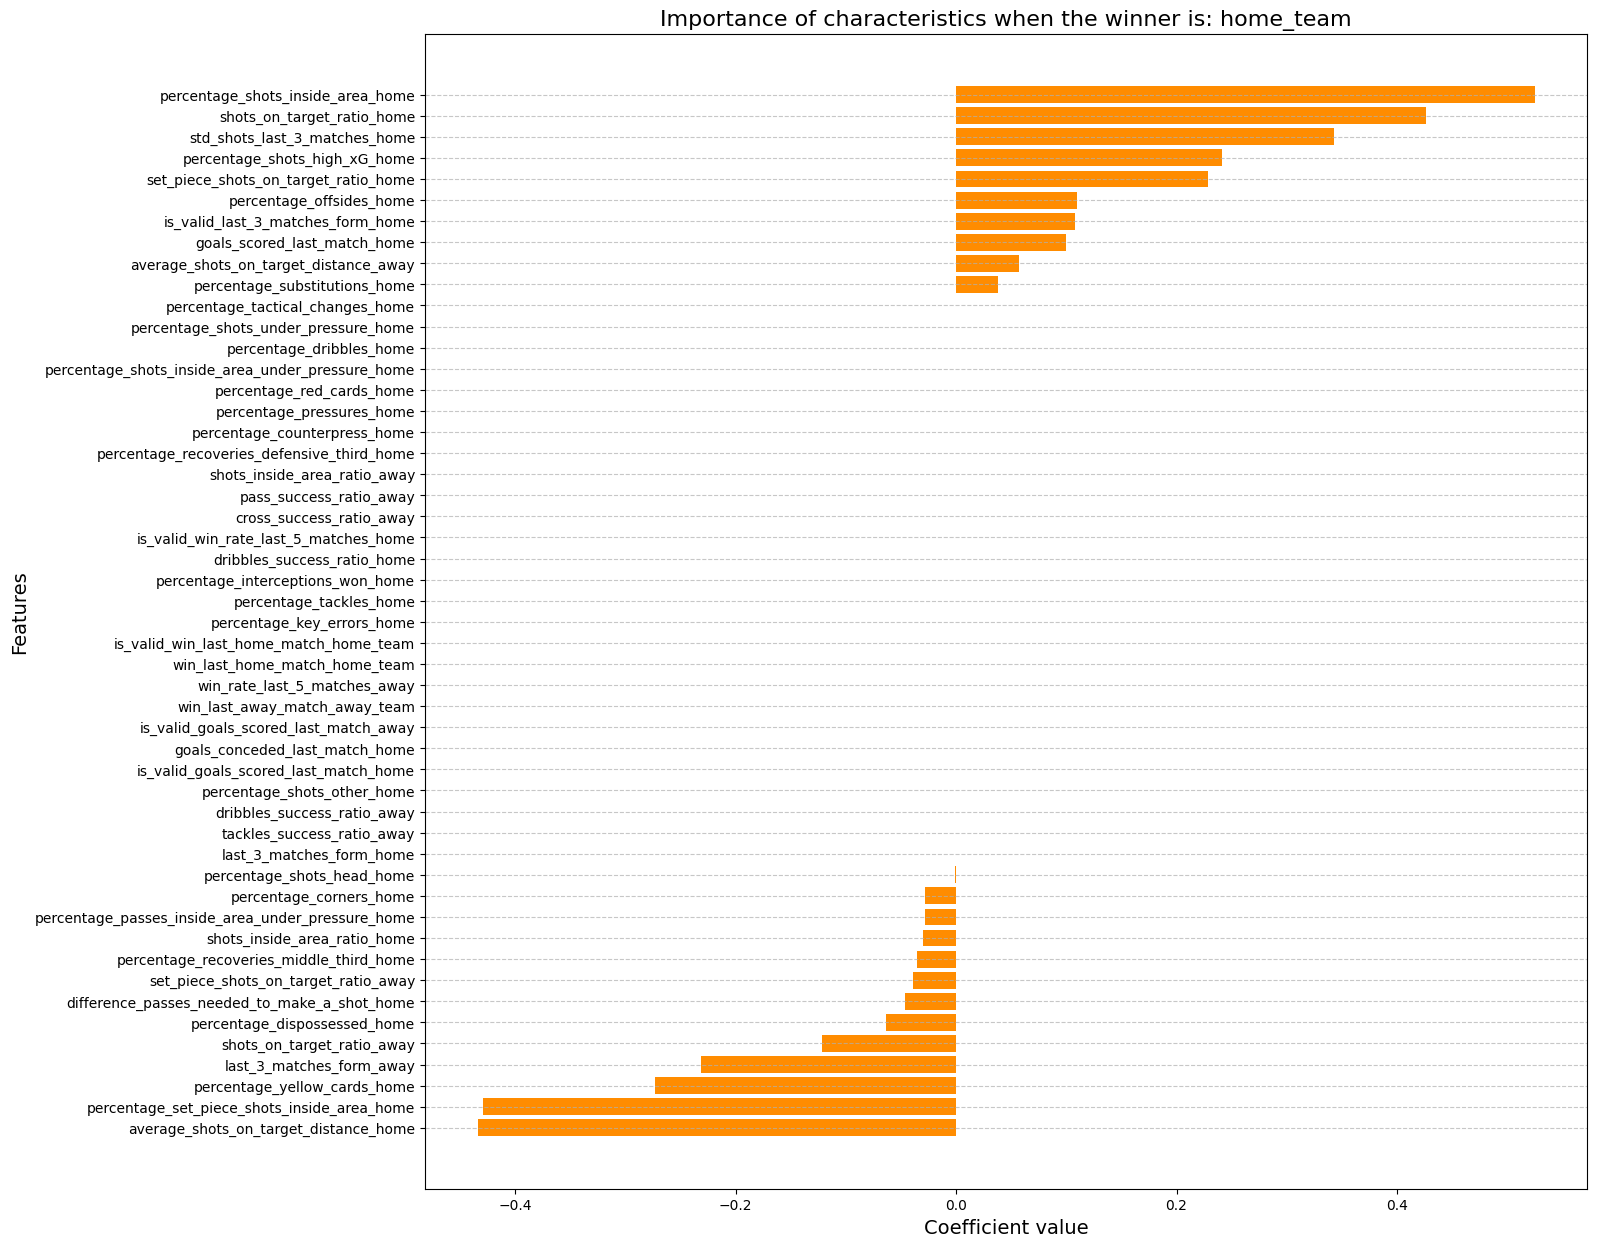

In [5]:
from src.analysis import laliga_global_analysis

laliga_global_analysis(best_model_LaLiga, feature_names_reduced_LaLiga, encoder_LaLiga)

Vamos a analizar cada uno de estos gr치ficos:

- **Importancia de caracter칤sticas para la victoria del equipo visitante (*away_team*)**: Las caracter칤sticas en este gr치fico aumentan la probabilidad de que el equipo visitante gane el partido.
    - **Caracter칤sticas que favorecen la victoria del equipo visitante**: 游늳
        - `difference_passes_needed_to_make_a_shot_home`: Si el equipo local necesita m치s pases para generar un tiro, su ataque es menos eficiente, lo que favorece al visitante.
        - `shots_on_target_ratio_away`: Un equipo visitante con un alto porcentaje de tiros a puerta tiene m치s probabilidades de marcar y ganar.
        - `percentage_shots_head_home`: Al aumentar estos porcentajes puede significar que el equipo local no esta encontrando otro recurso que no sea el juego a칠reo para atacar al equipo visitante debido a que consiguen defender bien.
        - `percentage_red_cards_home`: Si aumenta significa que el equipo local ha perdido alg칰n jugador lo cual hace que este en inferioridad y que tengan que cambiar los planes lo cual favorece al equipo visitante.
        - `percentage_key_errors_home`: M치s errores clave del equipo local que el equipo visitante que pueden ser aprovechados por el visitante.
        - `percentage_corners_home`: El equipo local esta fallando m치s lo cual esta derivando en que las jugadas acaben en m치s corners que en goles.
        - `win_last_away_match_away_team`: Tambi칠n influye que el equipo visitante ganase su 칰ltimo partido como visitante ya que esto puede indicar una din치mica positiva.
        - `percentage_shots_under_pressure_home`: Entre m치s tiros haya hecho con presi칩n el equipo local que el visitante, m치s probabilidades tendr치 de no meter gol el equipo local.
        - `shots_inside_area_ratio_away`: Entre mayor sea el ratio de tiros dentro del 치rea del equipo visitante respecto a sus tiros en el partido, mayor probabilidad tiene de marcar gol ya que el tiro ser치 m치s peligroso.
        - `cross_sucess_ratio_away`, `passes_success_ratio_away`: Entre mayor sean estos ratios, mayor acierto se ha tenido en la circulaci칩n del bal칩n por el equipo visitante lo cual le favorece.
        - `percentage_passes_inside_area_under_pressure_home`: Entre mayor sea el porcentaje, significa que el equipo visitante presiona m치s los pases en el 치rea que el equipo local lo cual influye en que no puedan jugar de manera c칩moda cerca de la porter칤a rival y tengan menos facilidad de meter gol los rivales (locales).
    - **Caracter칤sticas que no favorecen la victoria del equipo visitante**: 游늴
        - `percentage_shots_high_xG_home`, `shots_on_target_ratio_home`: Si el equipo local tiene muchos tiros con un alto porcentaje de gol o un alto porcentaje de tiros a puerta, genera m치s peligro, por lo que esta caracter칤stica tiene un coeficiente negativo en la victoria del visitante.
        - `percentage_offsides_home`: Si el equipo local ha caido m치s veces en fuera de juego puede significar que est치n atacando m치s lo que puede implicar que mantengan m치s tiempo la pelota y que est칠n constantemente buscando la espalda del equipo visitante.
        - `percentage_tackles_home`: significa que el equipo local hace m치s tackles que el equipo visitante lo cual puede influir negativamente sobre el equipo visitante ya que puede llevar a m치s recuperaciones por parte del equipo local o puede llevar a que cortan jugadas prometedoras del equipo visitante.
        - `goals_scored_last_match_home`: Si el equipo local viene de marcar una gran cantidad de goles esto puede influir en que el equipo local vengan motivados y en un buen estado de forma lo cual influye negativamente en el equipo visitante.
        - `dribbles_sucess_ratio_home`: Entre mayor sea el ratio de regates completados por el equipo local, mayor capacidad para superar a jugadores del equipo visitante han tenido lo cual puede implicar situaciones peligrosas en el juego a favor del equipo visitante.
    - **Caracter칤sticas que no tienen importancia en la victoria del equipo visitante**:
        - `last_3_matches_form_home`, `last_3_matches_form_away`: Parece ser que la forma de los 칰ltimos partidos de los dos equipos no influye en una posible victoria del equipo visitante.
        - `percentage_yellow_cards_home`: El porcentaje de tarjetas amarillas del equipo local respecto al total del partido no influye en la victoria del equipo visitante.
        - `percentage_shots_inside_area_home`: La cantidad de tiros dentro del 치rea del equipo local respecto al total del partido (local+visitante) no influye en la victoria del equipo visitante.
        - `percentage_recoveries_defensive_third_home`, `percentage_recoveries_middle_third_home`: La cantidad de recuperaciones del equipo local en el cualquier tercio del campo respecto al total del partido no influye en la victoria del equipo visitante.
        - `average_shots_on_target_distance_away`: La distancia media de donde se hagan los tiros a puerta del equipo visitante no influye en la victoria del equipo visitante.
        - `percentage_pressures_home`: La cantidad de presiones del equipo local respecto al total no influye en la victoria del equipo visitante.
        - `percentage_shots_inside_area_under_pressure_home`, `percentage_dribbles_home`... son algunas de las dem치s caracter칤sticas que no influyen en la victoria del equipo visitante.
    - **Conclusi칩n**: Para que un equipo visitante tenga una mayor probabilidad de ganar, necesita ser eficiente en ataque, aprovechar los errores y dificultades del equipo local, y contar con una din치mica positiva previa en partidos fuera de casa. Sin embargo, si el equipo local logra generar peligro con tiros de calidad, una defensa s칩lida y un juego ofensivo activo, la victoria del visitante se vuelve menos probable. Algunos factores que no son infuyentes son: la din치mica general que se lleve en varios partidos atr치s (sin embargo, partidos justo anteriores s칤), recuperaciones en cualquier tercio del campo, tarjetas amarillas...

- **Importancia de caracter칤sticas para el empate (*draw*)**: El empate en un partido suele estar influenciado por un equilibrio en las m칠tricas de ataque y defensa de ambos equipos. Algunas observaciones clave:
    - **Caracter칤sticas que favorecen el empate**: 游늳
        - `percentage_tactical_changes_home`: Si el equipo local realiza m치s cambios t치cticos durante el partido puede estar ajustando su estrategia constantemente, lo que puede evitar que el equipo visitante imponga su dominio y llevar el partido a un empate.
        - `percentage_recoveries_middle_third_home`: Un alto porcentaje de recuperaciones en el tercio medio por el equipo local indica un partido trabado en el centro del campo, con dificultades para que alguno de los equipos genere oportunidades claras.
        - `percentage_counterpress_home`: Una alta presi칩n tras p칠rdida por parte del equipo local impide que el equipo rival lance ataques r치pidos, manteniendo el juego m치s equilibrado.
        - `last_3_matches_form_away`: Si el equipo visitante ha tenido un buen rendimiento en los 칰ltimos tres partidos, puede ser menos propenso a perder a pesar de jugar fuera, aumentando la probabilidad de un empate.
        - `percentage_recoveries_defensive_third_home`: Si el equipo local recupera muchos balones en su tercio defensivo, evita que el equipo visitante genere muchas ocasiones de gol, lo que favorece un partido con pocos goles y, por ende, un empate.
    - **Caracter칤sticas que no favorecen el empate**: 游늴
        - `cross_success_ratio_away`, `pass_success_ratio_away`: Si el equipo visitante tiene un alto porcentaje de acierto en pases y centros, es m치s probable que genere situaciones de peligro y pueda romper el empate con un gol.
        - `set_piece_shots_on_target_ratio_home`: Un equipo local que tiene un alto porcentaje de tiros a puerta desde jugadas a bal칩n parado puede aprovechar estas situaciones para ganar el partido.
        - `dribbles_success_ratio_away`: Si el equipo visitante tiene un alto ratio de regates significa que en varios momneto ha podido estar en superioridad y de esta manera tener m치s ocasiones para ganar el partido.
        - `win_last_away_match_away_team`: Si el equipo visitante ha ganado su 칰ltimo partido fuera de casa puede significar que viene en una buena din치mica fuera de casa y que puede ganar el partido y romper el empate.
        - `std_shots_last_3_matches_home`: Significa que el equipo local mantiene un n칰mero de tiros bastante constante en los partidos lo que puede signficar que si est치 en una mala din치mica tira muy poco y puede perder el partido o si est치 en una buena din치mica tira mucho y puede ganar el partido rompiendo as칤 el empate.
    - **Caracter칤sticas que no tienen importancia en el empate**:
        - `win_rate_last_5_matches_away`: La tasa de victorias del equipo visitante en los 칰ltimos cinco partidos no parece ser un factor determinante para el empate.
        - `percentage_tackles_home`: La cantidad de entradas realizadas por los equipos no tiene una relaci칩n clara con la probabilidad de empate.
        - `percentage_interceptions_won_home`: A pesar de ser una m칠trica defensiva importante, no tiene un impacto significativo en el resultado final del partido.
        - `percentage_shots_inside_area_under_pressure_home`: A pesar de indicar situaciones de presi칩n en el 치rea, no parece afectar la probabilidad de empate.
        - `difference_passes_needed_to_make_a_shot_home`, `percentage_shots_high_xG_home`, `shots_on_target_ratio_home`, `goals_scored_last_match_home`, `goals_conceded_last_match_home`, `percentage_red_cards_home`, `percentage_yellow_cards_home`... son algunas de las m칠trica que no tienen importancia a la hora de predecir un empate.
    - **Conclusi칩n**: Un empate suele ser el resultado de un partido equilibrado donde ninguno de los equipos logra imponerse claramente. Factores como la gesti칩n t치ctica, las recuperaciones en el medio campo, la solidez defensiva y la estabilidad en el rendimiento reciente pueden favorecer un empate. Por otro lado, si uno de los equipos demuestra una alta efectividad en ataque, mayor precisi칩n en pases y centros, o un dominio en jugadas a bal칩n parado, la probabilidad de empate disminuye. Finalmente, ciertos aspectos como el rendimiento en partidos anteriores o m칠tricas defensivas espec칤ficas no parecen influir directamente en la probabilidad de que el partido termine en empate.

- **Importancia de caracter칤sticas para la victoria del equipo local (*home_team*)**: Las caracter칤sticas en este gr치fico aumentan la probabilidad de que el equipo visitante gane el partido.
    - **Caracter칤sticas que favorecen la victoria del equipo local**: 游늳
        - `percentage_shots_inside_area_home`: Un mayor porcentaje de tiros dentro del 치rea indica que el equipo local est치 generando oportunidades claras de gol.
        - `shots_on_target_ratio_home`: Un equipo local con un alto porcentaje de tiros a puerta tiene m치s probabilidades de marcar goles.
        - `std_shots_last_3_matches_home`: Una menor variabilidad en los tiros en los 칰ltimos tres partidos puede indicar que el equipo local mantiene una producci칩n ofensiva constante.
        - `percentage_shots_high_xG_home`: Un equipo local que logra disparos con un alto xG (expectativa de gol) genera m치s ocasiones peligrosas.
        - `set_piece_shots_on_target_ratio_home`: Indica que el equipo local aprovecha mejor sus oportunidades a bal칩n parado.
        - `percentage_offsides_home`: Si el equipo local cae en fuera de juego con frecuencia, indica una estrategia ofensiva agresiva y un dominio del ataque.
        - `goals_scored_last_match_home`: Si el equipo local ha metido muchos goles en el partido pasado puede reflejar que esta muy acertado de cara a puerta.
        - `average_shots_on_target_distance_away`: Si lo tiros que hace a puerta el equipo visitante son, de media, desde una distancia lejana puede indicar que no tienen otra forma de tratar de meter gol, se침alando un buen trabajo defensivo del equipo local y de esta manera dejando que se creen ocasiones claras de gol por el equipo visitante.
        - `percentage_substitutions_home`: Un mayor n칰mero de sustituciones puede reflejar una gesti칩n t치ctica efectiva para mantener el ritmo del partido.
    - **Caracter칤sticas que no favorecen la victoria del equipo local**: 游늴
        - `average_shots_on_target_distance_away`: Si los tiros que hace el equipo local de media tienen una distancia lejana tendr치n m치s complicado meter gol ya que generar치n menos peligro.
        - `percentage_yellow_cards_home`: Un alto n칰mero de tarjetas amarillas podr칤a reflejar un juego m치s agresivo, lo que puede generar faltas innecesarias y conceder oportunidades al rival por parte del equipo local.
        - `shots_on_target_ratio_away`: Un equipo visitante con un alto porcentaje de tiros a puerta puede generar ocasiones de peligro y complicar la victoria del local.
        - `last_3_matches_form_away`: Un equipo visitante que venga en buena forma puede complicar la victoria por parte del equipo local.
        - `difference_passes_needed_to_make_a_shot_home`: Si el equipo local necesita m치s pases para generar un tiro, su ataque es menos eficiente, lo que favorece al visitante.
        - `percentage_corners_home`: Si el equipo local tiene m치s corners que el equipo visitante esto puede significar que no est치n acertando en sus ataques mientras que el equipo visitante si.
        - `percentage_dispossessed_home`: Si el equipo local pierde m치s el bal칩n que el visitante eso puede significar que no son capaces de llevar el control del partido y de poder generar ocasiones de peligro.
    - **Caracter칤sticas que no tienen importancia en la victoria del equipo local**:
        - `win_rate_last_5_matches_away`: La tasa de victorias del equipo visitante en los 칰ltimos cinco partidos no parece afectar directamente la victoria del equipo local.
        - `percentage_pressures_home`, `percentage_counterpress_home`, `percentage_interceptions_won_home`, `percentage_tackles_home`: A pesar de ser m칠tricas defensivas relevantes, no tiene un impacto significativo en el resultado final.
        - `percentage_shots_inside_area_ratio_away`: El porcentaje de tiros dentro del 치rea del equipo visitante no parece afectar directamente la victoria del equipo local.
        - `dribbles_success_ratio_home`, `percentage_key_errors_home`, `percentage_yellow_cards_home`, `percentage_red_cards_home`... son otras de las m칠tricas que no influyen.
    - **Conclusi칩n**: La victoria del equipo local se basa en una combinaci칩n de eficiencia ofensiva, control del juego y solidez defensiva. Un equipo local con alta efectividad en tiros, generaci칩n de peligro dentro del 치rea y capacidad de adaptaci칩n t치ctica tiene m치s probabilidades de ganar. Adem치s, una defensa fuerte y una recuperaci칩n r치pida del bal칩n ayudan a reducir las oportunidades del rival. Sin embargo, si el equipo visitante es eficiente en ataque y genera peligro con tiros a puerta, la probabilidad de victoria local disminuye. Finalmente, algunos factores como la forma en los 칰ltimos partidos o ciertas m칠tricas defensivas no parecen influir directamente en la victoria del equipo local.

- **Conclusiones generales**: 
    - El equipo visitante gana cuando es efectivo en ataque, el equipo local falla en sus oportunidades, y la presi칩n del visitante limita el juego ofensivo del local.
    - El empate ocurre en partidos donde ninguno de los dos equipos logra imponerse, con un juego equilibrado en el medio campo, recuperaciones constantes y pocos errores defensivos.
    - El equipo local gana cuando genera muchas oportunidades claras de gol, mantiene un control efectivo del partido, y el visitante no logra responder con eficiencia en ataque.

Ahora comenzamos el an치lisis de explicabilidad utilizando SHAP. 

El an치lisis SHAP (SHapley Additive exPlanations) nos permite interpretar el impacto de cada caracter칤stica en la predicci칩n del modelo. A diferencia de los coeficientes lineales, SHAP captura interacciones entre variables y muestra el impacto individual de cada una en cada predicci칩n. En este documento analizaremos los resultados obtenidos para la predicci칩n de los partidos de La Liga.

Cada uno de los siguientes gr치ficos representa la importancia de las variables en la predicci칩n de cada posible resultado:
- Victoria del equipo visitante (away_team).
- Empate (draw).
- Victoria del equipo local (home_team).

**Interpretaci칩n de los gr치ficos SHAP**: Cada punto en el gr치fico representa un partido. Los valores en el eje X indican el impacto de una caracter칤stica espec칤fica en la predicci칩n del modelo:
- Valores positivos: Incrementan la probabilidad de que el partido termine con el resultado indicado.
- Valores negativos: Disminuyen la probabilidad del resultado.
- Color: Representa el valor de la caracter칤stica. Rojo indica valores altos y azul valores bajos.

In [6]:
explainer_LaLiga = shap.Explainer(best_model_LaLiga, X_train_reduced_LaLiga, feature_names=feature_names_reduced_LaLiga)
shap_values_LaLiga = explainer_LaLiga(X_test_reduced_LaLiga)

Clase 0: ['away_team']
Caracter칤sticas importantes (25):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'shots_inside_area_ratio_away', 'pass_success_ratio_away', 'cross_success_ratio_away', 'dribbles_success_ratio_home', 'set_piece_shots_on_target_ratio_away', 'is_valid_win_rate_last_5_matches_home', 'win_last_home_match_home_team', 'win_last_away_match_away_team', 'goals_scored_last_match_home', 'is_valid_goals_scored_last_match_home', 'is_valid_goals_scored_last_match_away', 'percentage_shots_high_xG_home', 'percentage_shots_head_home', 'percentage_shots_other_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_corners_home', 'percentage_tackles_home', 'percentage_key_errors_home', 'percentage_red_cards_home', 'percentage_offsides_home', 'percentage_shots_under_pressure_home', 'percentage_passes_inside_area_under_pressure_home', 'percentage_substitutions_home']
Caracter칤sticas SIN impacto (25):
['average_shots_on_target_distance_home', 'average_shots_on_

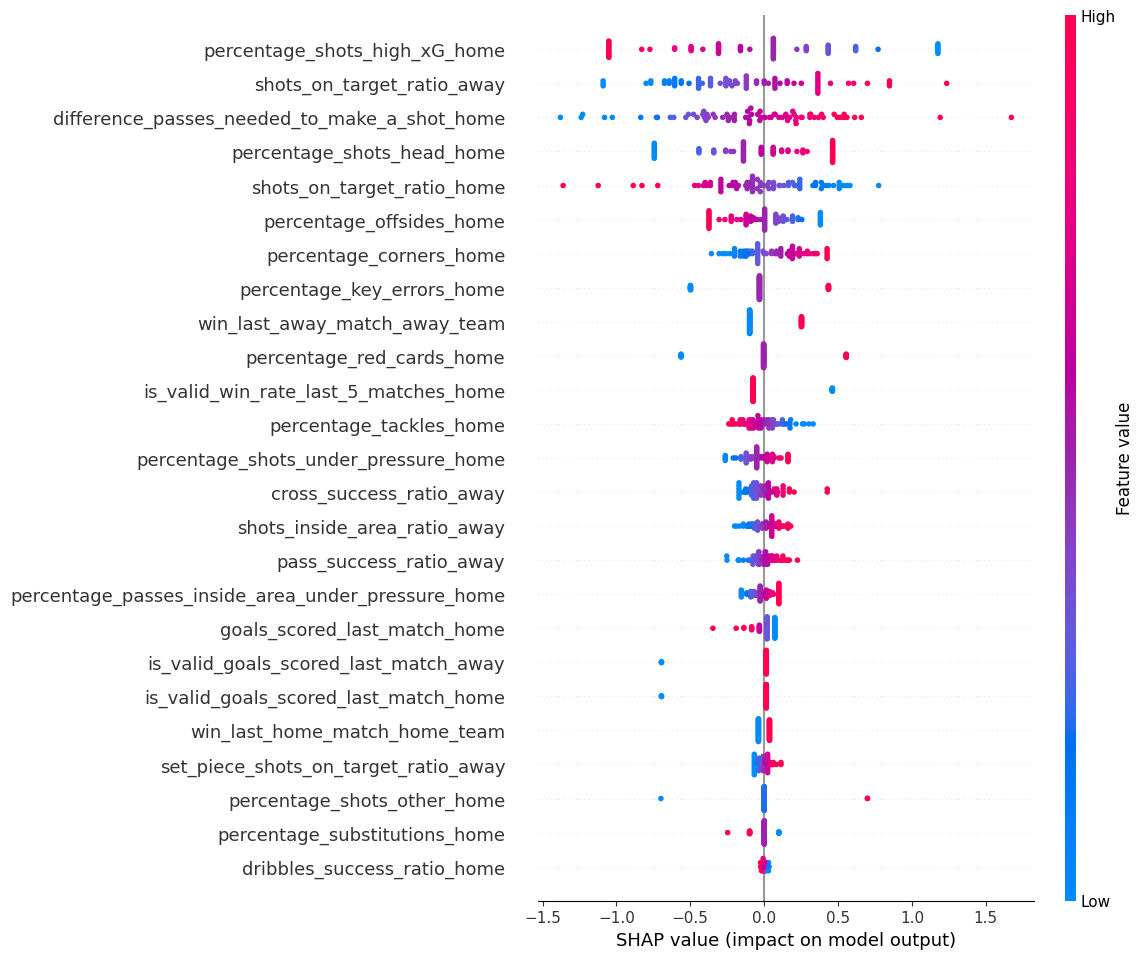

Clase 1: ['draw']
Caracter칤sticas importantes (13):
['pass_success_ratio_away', 'cross_success_ratio_away', 'dribbles_success_ratio_away', 'set_piece_shots_on_target_ratio_home', 'last_3_matches_form_away', 'win_last_away_match_away_team', 'std_shots_last_3_matches_home', 'percentage_shots_other_home', 'percentage_counterpress_home', 'percentage_recoveries_middle_third_home', 'percentage_recoveries_defensive_third_home', 'percentage_shots_inside_area_under_pressure_home', 'percentage_tactical_changes_home']
Caracter칤sticas SIN impacto (37):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'average_shots_on_target_distance_away', 'shots_inside_area_ratio_home', 'shots_inside_area_ratio_away', 'tackles_success_ratio_away', 'dribbles_success_ratio_home', 'set_piece_shots_on_target_ratio_away', 'last_3_matches_form_home', 'is_valid_last_3_matches_form_home', 'is_valid_win_rate_last_5_matches_home', 'win_rate_last_5_matches_away', 'win_la

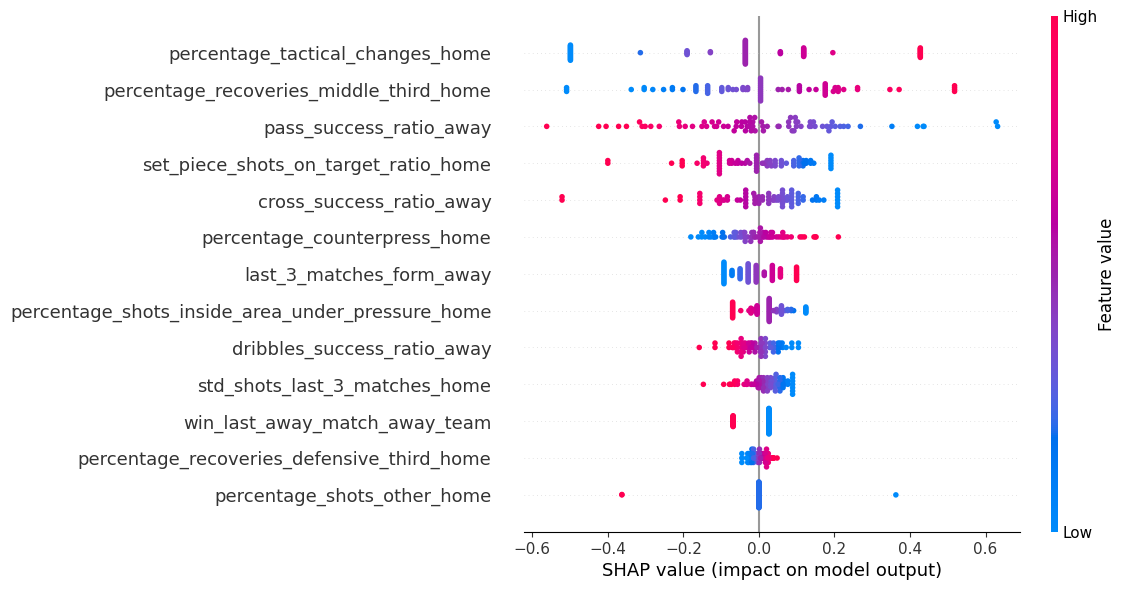

Clase 2: ['home_team']
Caracter칤sticas importantes (22):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'average_shots_on_target_distance_away', 'shots_inside_area_ratio_home', 'set_piece_shots_on_target_ratio_home', 'set_piece_shots_on_target_ratio_away', 'is_valid_last_3_matches_form_home', 'last_3_matches_form_away', 'goals_scored_last_match_home', 'std_shots_last_3_matches_home', 'percentage_shots_high_xG_home', 'percentage_shots_inside_area_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_corners_home', 'percentage_yellow_cards_home', 'percentage_offsides_home', 'percentage_dispossessed_home', 'percentage_recoveries_middle_third_home', 'percentage_passes_inside_area_under_pressure_home', 'percentage_set_piece_shots_inside_area_home', 'percentage_substitutions_home']
Caracter칤sticas SIN impacto (28):
['shots_inside_area_ratio_away', 'pass_success_ratio_away', 'cross_success_ratio_away', 'tackles_success_ratio_

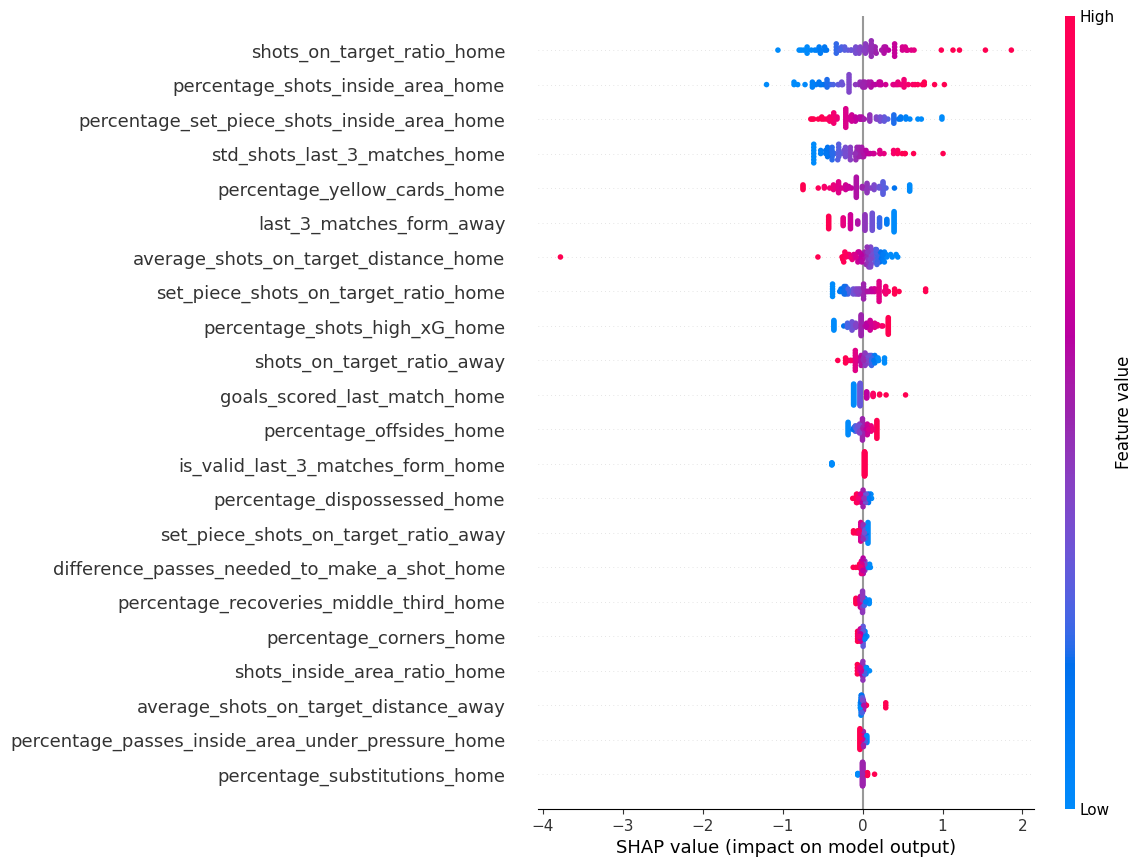

In [7]:
# definimos un umbral de importancia
threshold = 0.01

for i in range(shap_values_LaLiga.shape[2]):
    print(f"Clase {i}: {encoder_LaLiga.inverse_transform([i])}")
    # calculamos la importancia media de cada caracter칤stica y filtramos las caracter칤sticas que superen el umbral
    shap_importance = np.abs(shap_values_LaLiga.values[:, :, i]).mean(axis=0)
    important_features = np.where(shap_importance > threshold)[0]
    unimportant_features = np.where(shap_importance <= threshold)[0]
    print(f"Caracter칤sticas importantes ({len(important_features)}):")
    print([feature_names_reduced_LaLiga[idx] for idx in important_features])
    print(f"Caracter칤sticas SIN impacto ({len(unimportant_features)}):")
    print([feature_names_reduced_LaLiga[idx] for idx in unimportant_features])
    # si hay caracter칤sticas que superen el umbral, mostramos el gr치fico
    if len(important_features) > 0:
        shap.plots.beeswarm(shap_values_LaLiga[:, important_features, i], max_display=important_features.size)
    else:
        print(f"No hay caracter칤sticas con impacto mayor a {threshold} para la clase {i}.")

Vamos a analizar cada uno de los gr치ficos:

- **Victoria del equipo visitante**: Este gr치fico muestra las caracter칤sticas que favorecen o disminuyen la probabilidad de victoria del equipo visitante.
    - **Caracter칤sticas que favorecen la victoria del equipo visitante**: 游늳
        - `shots_on_target_ratio_away`: Un equipo visitante con un alto porcentaje de tiros a puerta tiene mayor probabilidad de marcar goles.
        - `difference_passes_needed_to_make_a_shot_home`: Si el equipo local necesita m치s pases para generar un tiro, su ataque es menos eficiente, favoreciendo al visitante.
        - `percentage_shots_head_home`: Puede indicar que el equipo local no est치 siendo capaz de hacer da침o al rival por el juego y que est치 intentando hacer centros al 치rea que desenbocan en remates de cabeza que suelen llevar menos peligro.
        - `percentage_corners_home`: Indica que el equipo local esta fallando m치s que el equipo visitante y por eso se dan m치s corners a su favor.
        - `percentage_key_errors_home`: M치s errores clave del equipo local pueden ser aprovechados por el visitante. Aunque, seg칰n el gr치fico, no suele darse en muchos partidos.
        - `win_last_away_match_away_team`: Si el equipo visitante gan칩 su 칰ltimo partido fuera de casa, puede indicar una din치mica positiva.
        - `percentage_red_cards_home`: Si el equipo local recibe una tarjeta roja, adem치s de quedarse con un hombre menos, tiene que cambiar de plan y tambi칠n podr칤a deberse a la frustraci칩n de uno de los jugadores del equipo local.
        - `percentage_shots_under_pressure_home`: Un equipo local que dispara bajo presi칩n es menos eficiente en ataque.
        - `cross_success_ratio_away`, `pass_success_ratio_away`: Un equipo visitante con alta precisi칩n en centros y pases genera m치s oportunidades de gol.
        - `shots_inside_area_ratio_away`: Si de los tiros del equipo visitante un alto porcentaje son desde dentro del 치rea se genera mucho m치s peligro que si fuese desde fuera del 치rea.
        - `set_piece_shots_on_target_ratio_away`: Si de los tiros que hace a bal칩n parado el equipo local, un alto porcentaje van a puerta se genera mucho m치s peligro.
    - **Caracter칤sticas que no favorecen la victoria del equipo visitante**: 游늴
        - `shots_on_target_ratio_home`: Un equipo local con un alto porcentaje de tiros a puerta genera peligro, reduciendo la probabilidad de victoria del visitante.
        - `percentage_shots_high_xG_home`: Si el equipo local logra tiros de alto *expected goals* (m칠trica que calcula probabilidad de que un tiro sea gol dependiendo de la situaci칩n del atacante, la posici칩n de los defensores, localizaci칩n en el campo, localizaci칩n del portero, etc.), aumenta sus probabilidades de marcar.
        - `percentage_offsides_home`: Un equipo local que cae en fuera de juego con frecuencia puede estar atacando m치s.
        - `percentage_tackles_home`: Una alta cantidad de tackles del equipo local puede indicar una defensa fuerte.
        - `goals_scored_last_match_home`: Si el equipo local viene de marcar muchos goles en su 칰ltimo partido puede influir en el 치nimo de los jugadores del equipo local e indicar que vienen de estar acertados de cara a gol.
        - `percentage_substitutions_home`: Si el equipo local hace varios cambios puede indicar que quieren mantener el ritmo del partido introduciendo jugadores nuevos.
        - `dribbles_sucess_ratio_home`: Aunque, seg칰n el gr치fico, con menos importancia, que haya un alto ratio de regates exitosos por parte del equipo local puede indicar que est치n superando la defensa del equipo visitante con facilidad y creando superioridades en ataque que puede desembocar en claras ocasiones de gol.
    - **Conclusi칩n**: Para que un equipo visitante tenga una mayor probabilidad de ganar, necesita ser eficiente en ataque, aprovechar los errores del equipo local y tener una racha positiva fuera de casa. Sin embargo, si el equipo local genera muchas ocasiones peligrosas y es fuerte en defensa, la victoria visitante se vuelve menos probable.

- **Empate**: Este gr치fico muestra las caracter칤sticas que favorecen o disminuyen la probabilidad de empate en un partido. El empate se suele asociar a partidos equilibrados donde ning칰n equipo impone una gran diferencia en ataque o defensa.
    - **Caracter칤sticas que favorecen el empate**: 游늳
        - `percentage_tactical_changes_home`: Si el equipo local realiza ajustes t치cticos constantes, el partido puede mantenerse equilibrado.
        - `percentage_recoveries_middle_third_home`: Muchas m치s recuperaciones en el centro del campo por parte del equipo local frente al visitante pueden indicar un partido trabado sin muchas ocasiones claras.
        - `percentage_counterpress_home`: Mayor n칰mero de presiones tras p칠rdida intensa por parte del equipo local frente al visitante puede impedir que el equipo visitante cree ocasiones de gol. Adem치s, el equipo local al jugar frente a su afici칩n deber칤a crecerse y mostrar un mejor juego, si es el equipo visitante quien hace una presi칩n intensa tras p칠rdida puede signficar que el equipo visitante esta siendo capaz de contrarrestar el juego del equipo local lo cu치l puede hacer que el equipo local se hunda.
        - `last_3_matches_form_away`: Si el equipo visitante ha tenido un buen rendimiento en los 칰ltimos tres partidos, puede ser menos propenso a perder y al jugar el equipo local frente a su afici칩n tambi칠n dar치 la cara al partido lo que puede indicar que el partido va a ser muy igualado.
        - `percentage_recoveries_defensive_third_home`: Si el equipo local recupera m치s balones que el equipo visitante en el tercio defensivo puede significar que las ocasiones que pudiera llegar tener el equipo visitante se est치n viendo frustradas por el equipo local.
    - **Caracter칤sticas que no favorecen el empate**: 游늴
        - `pass_success_ratio_away`, `cross_success_ratio_away`: Un equipo visitante con alta precisi칩n en pases o en centros puede generar ocasiones claras que el equipo local no esta sabiendo contrarrestar y ganar el partido.
        - `dribbles_success_ratio_away`: Un equipo visitante que logra completar muchos regates puede generar situaciones de peligro, reduciendo la probabilidad de empate.
        - `set_piece_shots_on_target_ratio_home`: Un equipo local efectivo en jugadas a bal칩n parado puede marcar y romper el empate.
        - `std_shots_last_3_matches_home`: Si el equipo local mantiene la producci칩n de tiros a los largo de los partidos anteriores constante puede significar que viene generando ocasiones de manera constante y que viene en un gran momento de forma a la hora de atacar.
        - `win_last_away_match_away_team`: Si el equipo visitante viene de ganar su 칰ltimo partido en casa que suele ser algo complicado, puede significar que viene con una buena din치mica jugando fuera de casa y que podr칤an llevarse la victoria en el partido.
    - **Conclusi칩n**: Un empate suele ser el resultado de un partido equilibrado donde ninguno de los equipos logra imponerse claramente. Factores como la gesti칩n t치ctica, las recuperaciones en el medio campo y la solidez defensiva pueden favorecer un empate. Por otro lado, si uno de los equipos demuestra una alta efectividad en ataque, dominio del juego y buenos resultados pasados, la probabilidad de empate disminuye.

- **Victoria del equipo local**: Este gr치fico muestra las caracter칤sticas que favorecen o disminuyen la probabilidad de victoria del equipo local.
    - **Caracter칤sticas que favorecen la victoria del equipo local**: 游늳
        - `shots_on_target_ratio_home`: Un alto porcentaje de tiros a puerta del equipo local aumenta la probabilidad de victoria.
        - `percentage_shots_inside_area_home`: Mayor n칰mero de tiros dentro del 치rea del equipo local que del visitante, son generalmente m치s peligrosos y aumentan la probabilidad de marcar.
        - `std_shots_last_3_matches_home`: Si el equipo local mantiene la producci칩n de tiros a los largo de los partidos anteriores constante puede significar que viene generando ocasiones de manera constante y que viene en un gran momento de forma a la hora de atacar.
        - `percentage_shots_high_xG_home`: Indica que el equipo local genera ocasiones de alta calidad.
        - `set_piece_shots_on_target_ratio_home`: Si de las jugadas a bal칩n parado del equipo local, un alto n칰mero han ido a puerta puede influir positivamente en la victoria del equipo local.
        - `goals_scored_last_match_home`: Si el equipo local viene de marcar varios goles en su 칰ltimo partido puede mantener una racha positiva.
        - `percentage_substitutions_home`: Indica que el equipo local gestiona bien sus cambios para mantener el rendimiento en el partido.
        - `average_shots_on_target_distance_away`: Si la distancia media de los tiros del equipo visitante es muy alta, significa que se ha generado poco peligro con los tiros lo que puede influir en que no han sido capaz de hacer da침o al equipo local.
    - **Caracter칤sticas que no favorecen la victoria del equipo local**: 游늴
        - `shots_on_target_ratio_away`: Un equipo visitante con buena precisi칩n en tiros puede complicar la victoria local.
        - `percentage_yellow_cards_home`: Un equipo local con muchas tarjetas amarillas puede estar cometiendo errores que beneficien al rival.
        - `last_3_matches_form_away`: Un equipo visitante con buena racha en sus 칰ltimos partidos puede poner en peligro la victoria del equipo local.
        - `average_shots_on_target_distance_home`: Si la distancia media de los tiros del equipo local es muy alta, significa que se ha generado poco peligro con los tiros lo que puede influir en que no han sido capaz de hacer da침o al equipo visitante.
        - `percentage_dispossessed_home`: Si el n칰mero de p칠rdidas del equipo local es mayor que la del visitante puede significar que el equipo local est치 siendo poco preciso con respecto al equipo visitante lo que genera una clara ventaja a favor del equipo local.
    - **Conclusi칩n**: La victoria del equipo local se basa en una combinaci칩n de eficiencia ofensiva, control del juego y solidez defensiva. Un equipo local con alta efectividad en tiros, generaci칩n de peligro dentro del 치rea y capacidad de adaptaci칩n t치ctica tiene m치s probabilidades de ganar. Sin embargo, si el equipo visitante es eficiente en ataque y genera peligro con tiros a puerta, la probabilidad de victoria local disminuye.

- **Conclusiones generales**:
    - La victoria del equipo visitante se asocia a una mayor eficiencia ofensiva y dificultades del equipo local en la creaci칩n de oportunidades.
    - Los empates ocurren en partidos con equilibrio t치ctico, muchas recuperaciones en el mediocampo y presi칩n constante.
    - La victoria del equipo local se relaciona con un ataque efectivo, dominio en tiros de alta calidad y creaci칩n de oportunidades claras por parte del equipo local.